In [1]:
import os
import av
import cv2
import numpy as np
import pandas as pd
import subprocess
from PIL import Image
import moviepy.editor as mp

from IPython.display import Video

In [3]:
def generate_video(image_folder='.', fps=1):
    output_filename = os.path.join(image_folder, 'video.mp4')

    image_paths = sorted([img for img in os.listdir(image_folder) 
                          if img.endswith(".jpg") or
                             img.endswith(".jpeg") or
                             img.endswith(".png")],
                         key=lambda x: int(x.split('.')[0]))

    container = av.open(output_filename, "w")
    stream = container.add_stream("h264", fps)
    # Запись изображений в видео
    for image_path in image_paths:
        img = cv2.imread(os.path.join(image_folder, image_path))
        frame = av.VideoFrame.from_ndarray(img, format="rgb24")
        packet = stream.encode(frame)
        container.mux(packet)
    # Завершение записи видео
    packet = stream.encode(None)  # Посылаем None, чтобы завершить видеопоток
    container.mux(packet)
    # Закрытие видеопотока
    container.close()

    print(f"Видео сгенерировано: {output_filename}")

Видео сгенерировано: data/out1/video.mp4


In [ ]:
# Вызов функции генерации видео
generate_video(image_folder='data/out1')

In [2]:
def trim_video(input_file, output_file, start_time, end_time):
    # Загрузка видеофайла
    video_clip = mp.VideoFileClip(input_file)

    # Обрезка видео
    trimmed_clip = video_clip.subclip(start_time, end_time)

    # Сохранение обрезанного видео в новый файл
    trimmed_clip.write_videofile(output_file)

    # Освобождение ресурсов
    video_clip.close()
    trimmed_clip.close()

In [11]:
trim_video(input_file="data/D03_20230523134844.mp4",
           output_file="data/video_10_50.mp4",
           start_time=10,
           end_time=50)

Moviepy - Building video data/video_10_50.mp4.
Moviepy - Writing video data/video_10_50.mp4



Moviepy - Done !
Moviepy - video ready data/video_10_50.mp4


In [ ]:
# https://github.com/analyticdan/motion-heatmap

def decay(accumulator, decay_const):
    return accumulator / decay_const

def rejuvenate(fgmask, accumulator, rejuvenate_const):
    fgmask = np.where(fgmask > 0, 1, 0)
    fgmask = np.stack((fgmask,) * 3, axis=-1)
    return np.maximum(accumulator, fgmask * rejuvenate_const)

def process_video(input_file='input_video.mp4', output_file='out.mp4', output=False, decay_rate=1.01):
    video = cv2.VideoCapture(input_file)
    if not video.isOpened():
        print("Ошибка при открытии видеофайла.")
        return
    
    frame_shape = (int(video.get(4)), int(video.get(3)), 3)
    decay_const = np.full(frame_shape, [decay_rate, 1, 1])
    rejuvenate_const = np.full(frame_shape, [179, 225, 225])
    accumulator = np.full(frame_shape, [0, 225, 225])
    
    bg_subtractor = cv2.bgsegm.createBackgroundSubtractorMOG()
    
    frames = []
    
    while video.isOpened():
        try:
            ok, frame = video.read()
            if not ok:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            fgmask = bg_subtractor.apply(gray)
            accumulator = decay(accumulator, decay_const)
            accumulator = rejuvenate(fgmask, accumulator, rejuvenate_const)
            frame = cv2.cvtColor(accumulator.astype(np.uint8), cv2.COLOR_HSV2BGR)
            frames.append(frame)
        except KeyboardInterrupt:
            break
    
    if output:
        command = [
            'ffmpeg',
            '-y',  # Overwrite output file if it exists
            '-f', 'rawvideo',
            '-vcodec', 'rawvideo',
            '-s', f"{frame_shape[1]}x{frame_shape[0]}",  # size of one frame
            '-pix_fmt', 'bgr24',
            '-r', str(int(video.get(5))),  # frame rate of the input video
            '-i', '-',  # input comes from a pipe
            '-c:v', 'libx264',
            '-preset', 'ultrafast',
            '-crf', '25',  # constant rate factor
            output_file
        ]
        
        try:
            process = subprocess.Popen(command, stdin=subprocess.PIPE)
            for frame in frames:
                process.stdin.write(frame.tobytes())
            process.stdin.close()
            process.wait()
        except Exception as e:
            print("Ошибка при записи видео:", e)
            return
    
    video.release()
    return frames

images = process_video(input_file='data/video_10_50.mp4', output_file='data/video_10_50_motions.mp4', output=True, decay_rate=1.01)


In [14]:
Video("data/video_10_50.mp4", width=800, height=450)

In [ ]:
Video("data/video_10_50_motions.mp4", width=800, height=450)

In [13]:
def binarize_video(input_video_path, output_video_path, threshold=127, blur_kernel_size=5):
    # Открываем входное видео
    container = av.open(input_video_path, 'r')
    
    # Получаем видеопоток и его параметры
    video_stream = container.streams.video[0]
    width = video_stream.width
    height = video_stream.height
    fps = video_stream.average_rate
    
    # Инициализируем выходное видео
    output_container = av.open(output_video_path, 'w')
    output_video_stream = output_container.add_stream('h264', rate=fps)
    output_video_stream.width = width
    output_video_stream.height = height
    
    # Проходим по всем кадрам во входном видео
    for packet in container.demux():
        for frame in packet.decode():
            # Получаем изображение из кадра
            img = frame.to_image()
            img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  # Преобразуем PIL изображение в массив NumPy
            
            # Применяем размытие к изображению
            blurred_img = cv2.GaussianBlur(img, (blur_kernel_size, blur_kernel_size), 0)
            
            # Бинаризуем размытое изображение
            gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)
            _, binary_img = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY)
            
            # Преобразуем изображение обратно в формат PIL для сохранения
            binary_img_pil = Image.fromarray(binary_img)
            
            # Создаем кадр av.VideoFrame из бинаризованного изображения
            frame = av.VideoFrame.from_image(binary_img_pil)
            
            # Записываем кадр в выходное видео
            for packet in output_video_stream.encode(frame):
                output_container.mux(packet)
    # Завершение записи видео
    packet = output_video_stream.encode(None)  # Посылаем None, чтобы завершить видеопоток
    output_container.mux(packet)
    # Закрываем объекты
    output_container.close()
    container.close()

# Пример использования функции
binarize_video("data/out1/video.mp4", "data/out1/binary.mp4", threshold=140, blur_kernel_size=3)

In [14]:
Video("data/out1/binary.mp4", width=800, height=450)

## Обучение

In [18]:
df = pd.read_excel('data/out1/D03_20230523134844.mp4.xlsx')
df

NameError: name 'pd' is not defined

In [17]:
duration = len(df.index)
print(duration)

NameError: name 'df' is not defined

In [5]:
print(df.loc[:, ['minNegPressure', 'meanNegPressure', 'maxNegPressure']])

    minNegPressure  meanNegPressure  maxNegPressure
0             -0.1             -0.1            -0.1
1             -0.1             -0.1            -0.1
2             -0.1             -0.1            -0.1
3             -0.1             -0.1            -0.1
4             -0.1             -0.1            -0.1
..             ...              ...             ...
63            -0.1             -0.1            -0.1
64            -0.1             -0.1            -0.1
65            -0.1             -0.1            -0.1
66            -0.1             -0.1            -0.1
67            -0.1             -0.1            -0.1

[68 rows x 3 columns]


In [40]:
def plot_series(label, x_axis, series_list):
    """
    Построение графика для списка pandas.Series

    Параметры:
    - x_axis: числовая ось, которая будет использоваться как ось X
    - series_list: список pandas.Series для построения графика
    """
    names = []
    if isinstance(series_list, list):
        for series in series_list:
            plt.plot(x_axis, series.values)
            names.append(series.name)
    else:
        for column_name, values in series_list.items():
            plt.plot(x_axis, values)
            names.append(column_name)
    plt.xlabel('X')
    plt.ylabel('Values')
    plt.title(label)
    plt.legend(names)
    
    plt.show()

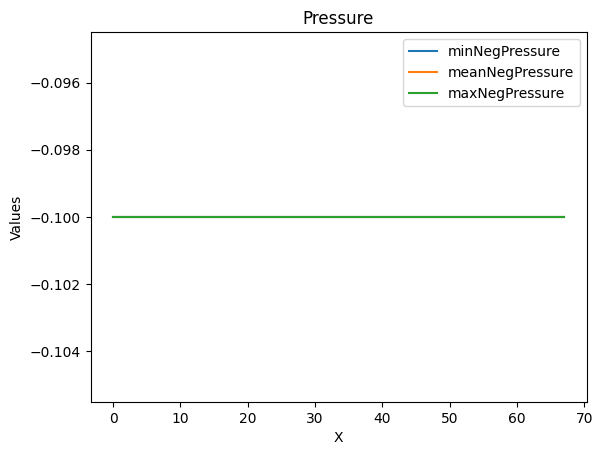

In [41]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('Pressure', x_axis, series_list=df.loc[:, ['minNegPressure', 'meanNegPressure', 'maxNegPressure']])

In [16]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('Humidity', x_axis, series_list=df.loc[:, ['minHumidity', 'meanHumidity', 'maxHumidity']])

NameError: name 'duration' is not defined

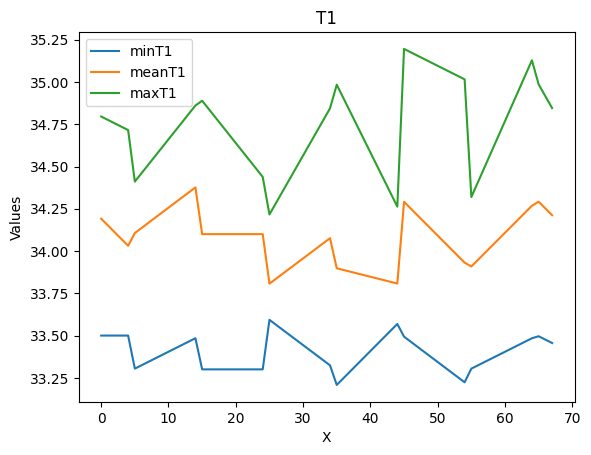

In [30]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T1', x_axis, series_list=df.loc[:, ['minT1', 'meanT1', 'maxT1']])

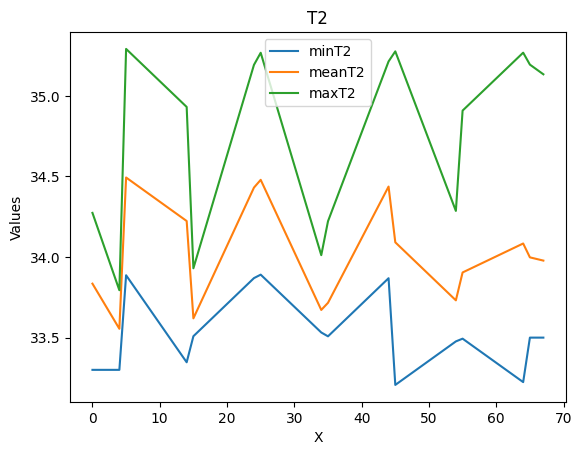

In [31]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T2', x_axis, series_list=df.loc[:, ['minT2', 'meanT2', 'maxT2']])

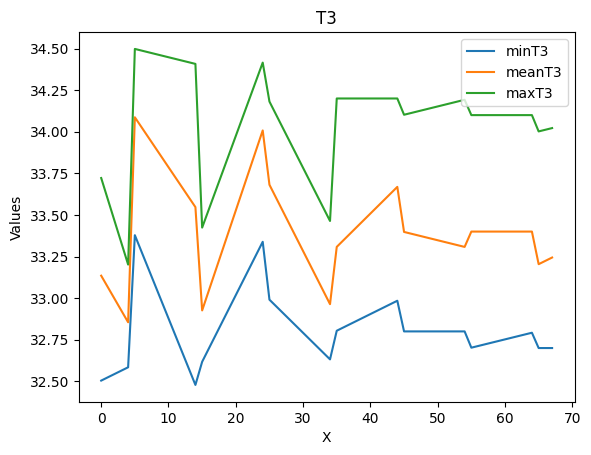

In [32]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T3', x_axis, series_list=df.loc[:, ['minT3', 'meanT3', 'maxT3']])

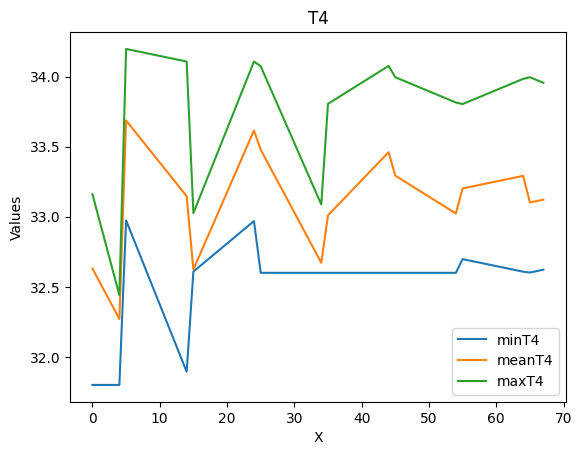

In [33]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T4', x_axis, series_list=df.loc[:, ['minT4', 'meanT4', 'maxT4']])

## Усредним значения с разных датчиков

In [35]:
def average_columns(df, columns, label=None):
    """
    Усредняет значения четырех колонок DataFrame.

    Параметры:
    - df: pandas.DataFrame
        Исходный DataFrame.
    - columns: list
        Список названий колонок, которые требуется усреднить.

    Возвращает:
    - pandas.Series
        Серия с усредненными значениями.
    """
    
    return pd.Series(df[columns].mean(axis=1), name=label)

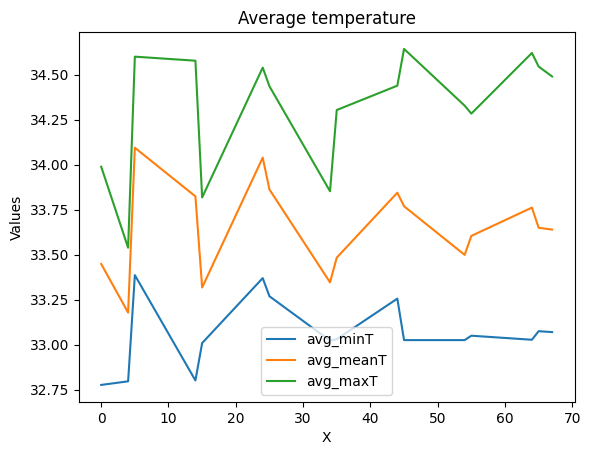

In [43]:
avg_min_temp = average_columns(df, ['minT1', 'minT2', 'minT3', 'minT4'], 'avg_minT')
avg_mean_temp = average_columns(df, ['meanT1', 'meanT2', 'meanT3', 'meanT4'], 'avg_meanT')
avg_max_temp = average_columns(df, ['maxT1', 'maxT2', 'maxT3', 'maxT4'], 'avg_maxT')
# Создаем набор данных
x_axis = np.arange(0, duration) 
# Вызываем функцию для построения графика
plot_series('Average temperature', x_axis, series_list=[avg_min_temp, avg_mean_temp, avg_max_temp])